In [1]:
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from tcn import TCN, tcn_full_summary

from model.data_parser import convert_jaad_dict_to_df, get_JAAD_data

In [2]:
#Load data
data_dir = "C:/Users/max00/Documents/PoseRecognition/pedestrian-pose-recognition/data/JAAD_JSON_Labels/"

X, Y = convert_jaad_dict_to_df(get_JAAD_data(data_dir))

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
sp_X_train = sparse.lil_matrix(X_train.values)
sp_Y_train = sparse.lil_matrix(Y_train.values)
sp_X_test = sparse.csr_matrix(X_test.values)
sp_Y_test = sparse.csr_matrix(Y_test.values)

Starting to read JAAD json files!


# Random forest

In [13]:
classifier = ClassifierChain(
        classifier=RandomForestClassifier(n_estimators=100),
        require_dense=[False, True]
    )

classifier.fit(sp_X_train, sp_Y_train)
# predict
predictions = classifier.predict(sp_X_test)

print(metrics.hamming_loss(sp_Y_test, predictions))
print(metrics.accuracy_score(sp_Y_test, predictions))

0.04928611760909898
0.8362507058159232


In [16]:
classifier.fit(X_train, Y_train)
predictions = classifier.predict(X_test)
df = pd.DataFrame.sparse.from_spmatrix(predictions)

0.04839880616278132
0.8384286520932483


TypeError: len() of unsized object

In [28]:
print(metrics.hamming_loss(Y_test, df))
print(metrics.accuracy_score(Y_test, df))
i=0
for col in df:
    df = df.rename(columns={col: str(int(col))})
for col in Y_test.columns:
    print(col + " accury:")
    print(metrics.accuracy_score(Y_test[col], df[str(i)]) )
    i += 1

0.04839880616278132
0.8384286520932483
look accury:
0.9244171977091232
action accury:
0.9409534564814068
cross accury:
0.8945712672420747
hand_gesture accury:
0.9983867064612406
nod accury:
0.9996773412922482


# BinaryRelevance

In [ ]:
clf = BinaryRelevance(
        classifier=SVC(),
        require_dense=[False, True]
    )

clf.fit(sp_X_train, sp_Y_train)
prediction = clf.predict(sp_X_test)


print(metrics.hamming_loss(sp_Y_test, prediction))
print(metrics.accuracy_score(sp_Y_test, prediction))

# LSTM

In [7]:
features, coordinate_values = X_train.shape
model = Sequential()
model.add(LSTM(64, input_shape=(coordinate_values, 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4))  # output layer，units is the unit number for output

# compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy,
                  metrics=[tf.keras.metrics.F1Score(
                      average='weighted', threshold=0.5, name='f1_score', dtype=None)])

model.fit(X_train, Y_train, epochs=11, batch_size=32)

# prediction
predictions = model.predict(X_test)

results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, results)))

Epoch 1/4
1550/1550 [==============================] - 63s 38ms/step - loss: 0.1693 - accuracy: 0.8023
Epoch 2/4
1550/1550 [==============================] - 58s 37ms/step - loss: 0.1564 - accuracy: 0.8023
Epoch 3/4
1550/1550 [==============================] - 59s 38ms/step - loss: 0.1549 - accuracy: 0.8023
Epoch 4/4
388/388 [==============================] - 7s 15ms/step
[[0.2132335 ]
 [0.18973319]
 [0.14931498]
 ...
 [0.15488715]
 [0.2281002 ]
 [0.2570317 ]]
Evaluate on test data for col: look
97/97 [==============================] - 4s 34ms/step - loss: 0.1507 - accuracy: 0.8029
{'loss': 0.15074381232261658, 'accuracy': 0.8029361963272095}
Epoch 1/4
1550/1550 [==============================] - 62s 40ms/step - loss: 0.1439 - accuracy: 0.8229
Epoch 2/4
1550/1550 [==============================] - 59s 38ms/step - loss: 0.1264 - accuracy: 0.8514
Epoch 3/4
1550/1550 [==============================] - 61s 39ms/step - loss: 0.1259 - accuracy: 0.8514
Epoch 4/4
388/388 [=====================

# TCN

In [ ]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        model.add(Dense(128, activation='relu')),
        model.add(Dense(64, activation='relu')),
        model.add(Dense(32, activation='relu')),
        Dense(4)
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.5, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

m.fit(X_train, Y_train, epochs=8, steps_per_epoch=1000)
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Train model for: look
Epoch 1/4
  32/1000 [..............................] - ETA: 2:12 - loss: 1.1838 - accuracy: 0.6356

In [11]:
features, coordinate_values = X_train.shape
batch_size, time_steps, input_dim = None, 20, coordinate_values
tcn_layer = TCN(input_shape=(coordinate_values, 1))
# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

m = Sequential([
        tcn_layer,
        Dense(4)
    ])

m.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=[tf.keras.metrics.F1Score(
        average='weighted', threshold=0.5, name='f1_score', dtype=None)])

tcn_full_summary(m, expand_residual_blocks=False)

history = m.fit(X_train, Y_train,  epochs=4, steps_per_epoch=1000)
predictions = m.predict(X_test)
print("Complete")
results = m.evaluate(X_test, Y_test, batch_size=32)
print(dict(zip(m.metrics_names, results)))

Receptive field size = 253
Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Epoch 1/4
1000/1000 [==============================] - 128s 120ms/step - loss: 4.0742 - f1_score: 0.0023 - val_loss: 4.0398 - val_f1_score: 0.0000e+00
Epoch 2/4
1000/1000 [==============================] - 114s 114ms/step - loss: 4.0681 - f1_score: 0.0000e+00 - val_loss: 4.0398 - val_f1_score: 0.0000e+00
Epoch 3/4
1000/1000 [==============================] - 113s 113ms/step - loss: 4.0662 - f1_score: 0.0000e+00 - val_loss: 4.0398 - val_f1_score: 0.0000e+00
Epoch 4/4
1000/1000 [==============================] - 121s 121ms/step - loss: 4.0674 - f1_score: 0.0000e+00 - val_loss: 4.0398 - val_f1_score: 0.0000e+00


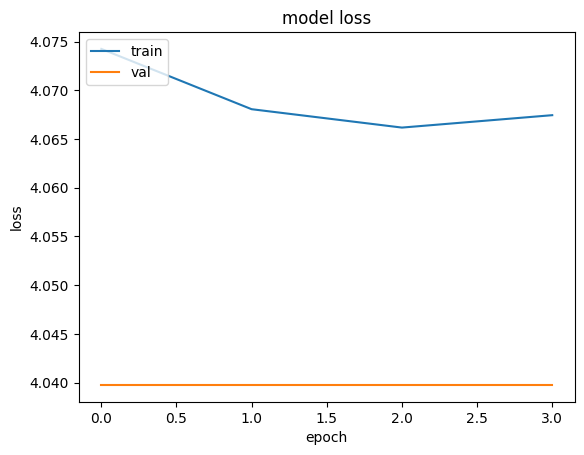

In [12]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()